# LSTM + SelfAttention
* Daily data

## Imports

In [2]:
import os
import random
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import scipy.stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
tqdm.pandas()

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm.keras import TqdmCallback

2023-04-04 14:50:11.807668: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 14:50:11.840417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# tf.config.list_physical_devices('GPU')

## Config

In [3]:
# Config
PROJECT_ID = "arpae-prod-ml"
B_CODES_TABLE = "B_CODES"

# Dataset path
dataset_path = "data/"

# Ouput
model_output = "models"

## Methods

In [4]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cluster_ids.append("all")
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.3 Load clustering results

In [5]:
### TSD Clustering
# clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")

### Station/Specie Clustering
clusters = pd.read_csv("../data/clusters/clustering_intervals.csv")

print(clusters.shape)
clusters.sample(3)

(363, 3)


,station_id,pol_var_id,cluster
352,13,B48031,9
122,5,B48032,7
25,1,B48034,2


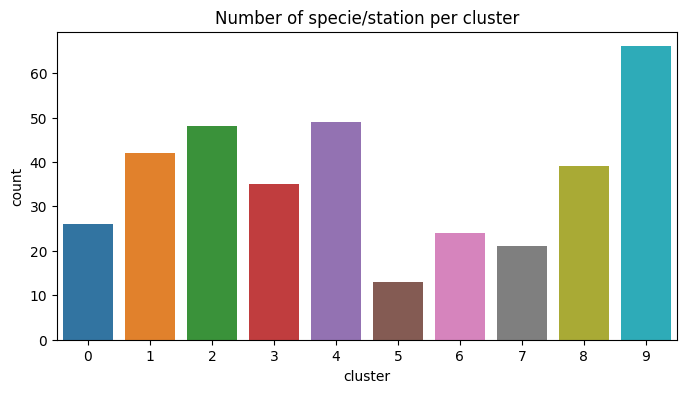

In [6]:
plt.figure(figsize=(8,4))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

## 1.4 Load dataset

In [7]:
window_size = 7
dataset_path = f"data/dataset_{window_size}D.feather"

df_dataset = pd.read_feather(dataset_path)
df_dataset.drop_duplicates(inplace=True)

print(df_dataset.shape)
df_dataset.head(3)

(1135250, 55)


,date,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,...,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label,season_label,trend_label,residual_label
0,2006-09-05,1,B48001,1,0.0,1.2,0.005621,0.036517,4.8,-10.0,...,3.01,3.01,3.87,5.59,4.73,4.30,3.01,-2.187625,14.478630,-9.281005
1,2006-09-06,1,B48001,1,0.0,1.2,0.001405,0.015520,1.2,-10.0,...,5.16,3.01,3.01,3.87,5.59,4.73,2.58,-5.432171,14.492767,-6.480596
2,2006-09-07,1,B48001,1,0.0,0.0,0.000000,0.000000,0.0,-10.0,...,3.01,5.16,3.01,3.01,3.87,5.59,2.58,-4.024898,14.498658,-7.893759


___

# 2. Data preprocess

In [8]:
# Convert dates to datetime format
df_dataset.date = pd.to_datetime(df_dataset.date)

In [9]:
# Sort dataset
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)

In [10]:
# Set datetime as index
df_dataset.set_index("date", inplace=True)

In [11]:
print(df_dataset.shape)
df_dataset.head(3)

(1135250, 54)


,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,...,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label,season_label,trend_label,residual_label
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05,1,B48001,1,0.0,1.2,0.005621,0.036517,4.8,-10.0,789.0,...,3.01,3.01,3.87,5.59,4.73,4.30,3.01,-2.187625,14.478630,-9.281005
2006-09-06,1,B48001,1,0.0,1.2,0.001405,0.015520,1.2,-10.0,789.0,...,5.16,3.01,3.01,3.87,5.59,4.73,2.58,-5.432171,14.492767,-6.480596
2006-09-07,1,B48001,1,0.0,0.0,0.000000,0.000000,0.0,-10.0,766.0,...,3.01,5.16,3.01,3.01,3.87,5.59,2.58,-4.024898,14.498658,-7.893759


___

# 3. Select data

### 3.1 Select Cluster

In [12]:
# Select species/stations from cluster result
def select_cluster_species(df, clusters, cluster_n):
    # Select Cluster pollen ids
    if cluster_n == "all":
        specie_cluster = clusters
    else:
        specie_cluster = clusters[clusters.cluster == cluster_n]

    # Select species/stations from cluster result
    df_feature = pd.merge(df.reset_index(), specie_cluster, on=["station_id", "pol_var_id"], how="inner")
    df_feature.station_id = df_feature.station_id.astype(int)
    df_feature.dropna(inplace=True)
    df_feature.set_index("date", inplace=True)

    assert len(specie_cluster) == len(df_feature[["station_id", "pol_var_id"]].drop_duplicates())
    return df_feature

### 3.4 Specie and station are added as a categorical feature to our model

In [13]:
def one_hot_encode_feat(df, columns):
    for col in columns:
        # Encode feature
        var_enc = pd.get_dummies(df[col], prefix=col)

        # Add one-hot encoded values to original dataframe
        df = pd.concat([df, var_enc], axis=1)
    return df

### 3.5 Select features

In [14]:
# def select_features(df, features, columns_to_shift, columns_to_encode):
#     # Add previous pollen day
#     for col in columns_to_shift:
#         shifted_feature_names = df.keys()[df.keys().str.contains(f"{col}_prev")]
#         features.extend(shifted_feature_names.tolist())

#     # Add one hot encodings of station and species
#     for col in columns_to_encode:
#         col_one_hot = df.keys()[df.keys().str.contains(f"{col}_")]
#         features.extend(col_one_hot.tolist())

#     features = np.array(features)
#     return features

### 3.6 Training/test split

In [15]:
def split_group(group):
    # Get group indexes
    group_idxs = group.index.values
    group_len = len(group_idxs)

    # Evaluate indexes for each split
    train_end = int(group_len * training_size)
    test_end = int(group_len * (training_size + test_size))
    val_end = int(group_len * (training_size + test_size + valid_size))

    # Selecting splits from indexes
    train_idx = group_idxs[:train_end]
    test_idx = group_idxs[train_end:test_end]
    val_idx = group_idxs[test_end:]

    return train_idx, test_idx, val_idx


def train_test_valid_split(df, y_label):
    # Set index back to integers
    df = df.copy()
    df.reset_index(inplace=True)

    # Group by station and pollen
    groups = df.groupby(["station_id", "pol_var_id"])

    # Split group indexes
    indexes = groups.apply(split_group).values
    indexes = np.array(indexes)

    # Parse group indexes
    training_idxs = np.hstack([np.sort(idxs[0]) for idxs in indexes])
    test_idxs = np.hstack([np.sort(idxs[1]) for idxs in indexes])
    valid_idxs = np.hstack([np.sort(idxs[2]) for idxs in indexes])

    # Create X, y from dataset
    X = df  # [features]
    y = df[[y_label, "date"]]

    # Split using indexes
    x_train, y_train = X.loc[training_idxs], y.loc[training_idxs]
    x_test, y_test = X.loc[test_idxs], y.loc[test_idxs]
    x_valid, y_valid = X.loc[valid_idxs], y.loc[valid_idxs]

    x_train.set_index("date", inplace=True)
    y_train.set_index("date", inplace=True)
    x_test.set_index("date", inplace=True)
    y_test.set_index("date", inplace=True)
    x_valid.set_index("date", inplace=True)
    y_valid.set_index("date", inplace=True)

    return x_train, y_train, x_test, y_test, x_valid, y_valid

### 3.7 Create timeseries_dataset_from_array

In [16]:
def create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid):
    train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_train[features],
        y_train,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_test[features],
        y_test,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_valid[features],
        y_valid,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    return train_dataset, test_dataset, valid_dataset

___

# 4. Model definition

### LSTM, MultiHeadAttention

In [17]:
# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     # LSTM Layer
#     lstm_1 = tf.keras.layers.LSTM(units=512, dropout=.2, return_sequences=True)(input_layer)
#     lstm_2 = tf.keras.layers.LSTM(units=256, dropout=.2, return_sequences=True)(lstm_1)
#     lstm_3 = tf.keras.layers.LSTM(units=128, dropout=.2, return_sequences=True)(lstm_2)

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_3, value=lstm_3, key=lstm_3)
#     attn_output = tf.keras.layers.Dense(units=128)(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=128)(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=64)(dropout_1)
#     dropout_2 = tf.keras.layers.Dropout(.2)(dense_lst_2)
#     dense_lst_3 = tf.keras.layers.Dense(units=32)(dropout_2)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_3)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
#     #optimizer = Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, loss="mse")
#     return model

# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
#     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=64, activation="relu")(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=16, activation="relu")(dropout_1)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
#     #optimizer = Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, loss="mse")
#     return model

In [18]:
def get_model(features_shape):
    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

    ### Multi head attention
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
    attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

    # Reshape attention layer
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=128)(att_reshape)
    dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
    dense_lst_2 = tf.keras.layers.Dense(units=64)(dropout_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [19]:
# ## nice, normalized data
# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     # LSTM layers
#     lstm_1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(input_layer)
#     lstm_2 = tf.keras.layers.LSTM(units=64)(lstm_1)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=32)(lstm_2)
#     dense_lst_2 = tf.keras.layers.Dense(units=16)(dense_lst_1)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Define optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")

#     # optimizer = Adam(learning_rate=learning_rate)
#     # model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=huber_delta, name="loss"))

#     return model

___

In [20]:
features = [
    'B13011_min_amin',
    'B13011_max_amax',
    'B13011_mean_mean',
    'B13011_std_mean',
    'B13011_sum_sum',
    'B14198_min_amin',
    'B14198_max_amax',
    'B14198_mean_mean',
    'B14198_std_mean',
    'B14198_sum_sum',
    'TEMP_min_amin',
    'TEMP_max_amax',
    'TEMP_mean_mean',
    'TEMP_std_mean',
    'TEMP_sum_sum',
    'station_lat_amax',
    'station_lon_amax',
    'station_H_piano_strada_amax',
    'station_H_mslm_amax',
    # 'seasonal_mean',
    # 'seasonal_prev_1',
    # 'trend_mean',
    # 'trend_prev_1',
    # 'residual_mean',
    # 'residual_prev_1',
    'week_amax',
    'PREC_amin',
    'PREC_mean',
    'PREC_std',
    'PREC_median',
    'PREC_amax',
    'PREC_skew',
    'PREC_kurtosis',
    'pol_value_amin',
    'pol_value_mean',
    'pol_value_std',
    'pol_value_median',
    'pol_value_amax',
    'pol_value_skew',
    'pol_value_kurtosis',
    'pol_value_prev_1',
    'pol_value_prev_2',
    'pol_value_prev_3',
    'pol_value_prev_4',
    'pol_value_prev_5',
    'pol_value_prev_6',
    'pol_value_prev_7',
    # 'pol_value_label',
    # 'season_label',
    # 'trend_label',
    # 'residual_label'
]

y_label = "pol_value_label"

# 5. Training Pipeline

In [21]:
def get_processed_data(cluster_n, log=False):
    # Select data from cluster (all if cluster_n is None)
    df_feature = select_cluster_species(df_dataset, clusters, cluster_n=cluster_n)

    # Shift pollen value to prev day (label)
    # df_feature = shift_pollen(df_feature)

    # Convert features to one hot encoding
    df_feature = one_hot_encode_feat(df_feature, columns_to_encode)

    if log:
        print("Dataset shape:", df_feature.shape)

    # Select features
    #features = list(df_feature.drop(["station_id", "pol_var_id", "cluster", "pol_value_label"], axis=1).keys())
    #y_label = "pol_value_label"

    #features = select_features(df_feature, features, columns_to_shift, columns_to_encode)
    if log:
        print(len(features), "features")
        print("Features: ", sorted(features))
    
    x_train, y_train, x_test, y_test, x_valid, y_valid = train_test_valid_split(df_feature, y_label)
    if log:
        print(f"x_training_size: {x_train.shape}, x_test_size: {x_test.shape}, x_valid_size: {x_valid.shape}")
    if log:
        print(f"y_training_size: {y_train.shape}, y_test_size: {y_test.shape}, y_valid_size: {y_valid.shape}")

    ### Verify station/pollen split dates
    # x_train.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_test.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_valid.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()

    train_dataset, test_dataset, valid_dataset = create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid)

    class dataset: pass
    dataset.cluster_n = cluster_n
    dataset.features = features
    dataset.x_train = x_train
    dataset.y_train = y_train
    dataset.x_test = x_test
    dataset.y_test = y_test
    dataset.x_valid = x_valid
    dataset.y_valid = y_valid
    dataset.train_dataset = train_dataset
    dataset.test_dataset = test_dataset
    dataset.valid_dataset = valid_dataset
    return dataset

In [22]:
def train_model(dataset, log=False):
    model_name = f"lstm_self-att_daily_cluster-{dataset.cluster_n}"
    model_output_path = f"{model_output}/{model_name}.h5"

    if os.path.exists(model_output_path):
        !rm $model_output_path

    print(f"Training model for cluster: {dataset.cluster_n}. Output folder: {model_output_path}")

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    early_stop = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_output_path, monitor="val_loss", mode="min", save_best_only=True)

    model = get_model(len(dataset.features))
    if log:
        print(model.summary())

    history = model.fit(
        dataset.train_dataset,
        validation_data=dataset.test_dataset,
        epochs=n_epochs,
        shuffle=True,
        verbose=0,
        # callbacks=[early_stop, model_checkpoint, reduce_lr, TqdmCallback(verbose=1)],
        callbacks=[early_stop, model_checkpoint, TqdmCallback(verbose=1)],
    )

    # Load the best model
    print("Loading best model")
    model = tf.keras.models.load_model(model_output_path)

    return history, model

## 5.1 Params

In [23]:
columns_to_encode = ["station_id", "pol_var_id"]

training_size, test_size = 0.75, 0.05
valid_size = np.round(1 - training_size - test_size, 5)

batch_size = 4096
window_day_size = 7

n_epochs = 100
learning_rate = 0.001

print("training_size:", training_size, "test_size:", test_size, "valid_size:", valid_size)

training_size: 0.75 test_size: 0.05 valid_size: 0.2


In [35]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())
# all_clusters.append("all")

# for debugging purpose
# all_clusters = random.sample(all_clusters, 1)
all_clusters = [4]
# all_clusters = ["all"]

print(f"Training clusters: {all_clusters}")

Training clusters: [4]


## 5.2 Launch training pipeline

In [36]:
trainings = []
for cluster_n in tqdm(all_clusters):
    # Get dataset
    dataset = get_processed_data(cluster_n=cluster_n, log=False)

    # Train dataset
    dataset.history, dataset.model = train_model(dataset)

    # Store results
    trainings.append(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Training model for cluster: 4. Output folder: models/lstm_self-att_daily_cluster-4.h5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-04-04 15:00:47.435967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:00:47.436303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [90901,1]
	 [[{{node Placeholder/_20}}]]
2023-04-04 15:00:50.492873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [6060,1]
	 [[{{

Restoring model weights from the end of the best epoch: 41.
Epoch 56: early stopping
Loading best model


___

# 6. Results

## 6.1 Loss training history

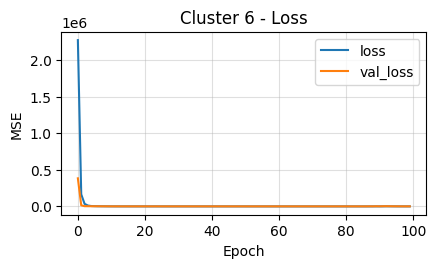

In [33]:
rows, cols = 5, 3
fig, axs = plt.subplots(rows, cols, figsize=(12, 12), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Loss")
    ax.plot(dataset.history.history["loss"])
    ax.plot(dataset.history.history["val_loss"])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend(["loss", "val_loss"], loc="upper right")
    ax.grid(alpha=0.4)
for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 6.2 Models MSE Train/Test/Valid

In [ ]:
cluster_model_mse = []
for dataset in tqdm(trainings):
    cluster_model_mse.append({
        "cluster_n": dataset.cluster_n,
        "train_mse": dataset.model.evaluate(dataset.train_dataset, verbose=False),
        "test_mse": dataset.model.evaluate(dataset.test_dataset, verbose=False),
        "valid_mse": dataset.model.evaluate(dataset.valid_dataset, verbose=False),
    })
cluster_model_mse = pd.DataFrame(cluster_model_mse)

fig, ax = plt.subplots(figsize=(10, 4))
cluster_model_mse.plot(x='cluster_n', kind='bar', ax=ax)
ax.set_title('Mean Squared Error vs. Cluster Size')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Mean Squared Error')
# plt.yscale("symlog")
plt.grid(alpha=.4)
plt.show()

## 6.3 Training/Test Model Predictions

In [ ]:
### Test on training data
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
for subpltn, _ in enumerate(trainings):
    predictions = dataset.model.predict(dataset.train_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.train_dataset, verbose=False)

    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Training preditcions - MSE: {np.round(mse, 2)}")
    ax.scatter(dataset.y_train.index, dataset.y_train.values, s=3, c="green", label="pol_value true")
    ax.scatter(dataset.y_train.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
    ax.set_ylabel('Pollen')
    ax.set_xlabel('Date')
    ax.grid(alpha=.4)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

In [ ]:
### Test on test data
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.test_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.test_dataset, verbose=False)

    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Test preditcions - MSE: {np.round(mse, 2)}")
    ax.scatter(dataset.y_test.index, dataset.y_test.values, s=3, c="green", label="pol_value true")
    ax.scatter(dataset.y_test.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
    ax.set_ylabel('Pollen')
    ax.set_xlabel('Date')
    ax.grid(alpha=.4)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 6.4 Validation data

2023-04-04 15:03:54.625950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [24263,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:03:54.626237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [24263,1]
	 [[{{node Placeholder/_20}}]]


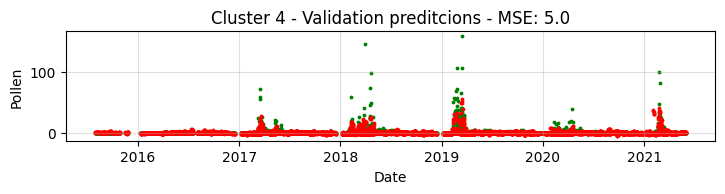

In [37]:
### Test on validation data
rows, cols = 6, 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 10), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.valid_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.valid_dataset, verbose=False)

    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Validation preditcions - MSE: {np.round(mse, 2)}")

    ax.scatter(dataset.y_valid.index[: -window_day_size + 1], dataset.y_valid[: -window_day_size + 1].values, s=3, c="green", label="pol_value true")
    ax.scatter(dataset.y_valid.index[: -window_day_size + 1], predictions, s=3, c="red", label="pol_value predicted")

    ax.set_ylabel("Pollen")
    ax.set_xlabel("Date")
    ax.grid(alpha=0.4)

for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 6.5 Validation data - Single cluster, all specie/pollen

In [29]:
cluster_wgt = _create_cluster_n_widget(clusters)
display(cluster_wgt)

Dropdown(description='Cluster id:', layout=Layout(width='50%'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'all'),…

In [39]:
tf.get_logger().setLevel("ERROR")

2023-04-04 15:05:14.443684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [767,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:14.443918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [761]
	 [[{{node Placeholder/_8}}]]


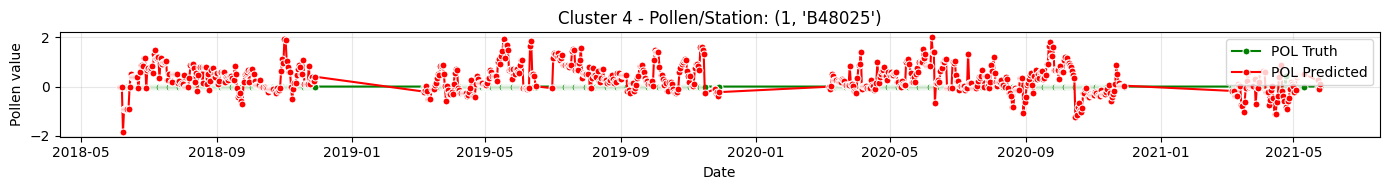

2023-04-04 15:05:14.750844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [580,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:14.751074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


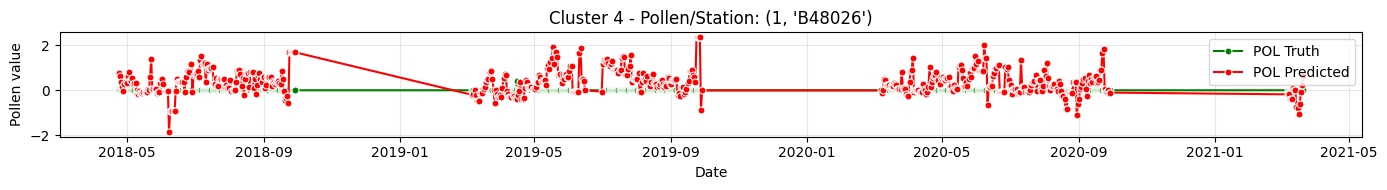

2023-04-04 15:05:15.007906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:15.008192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


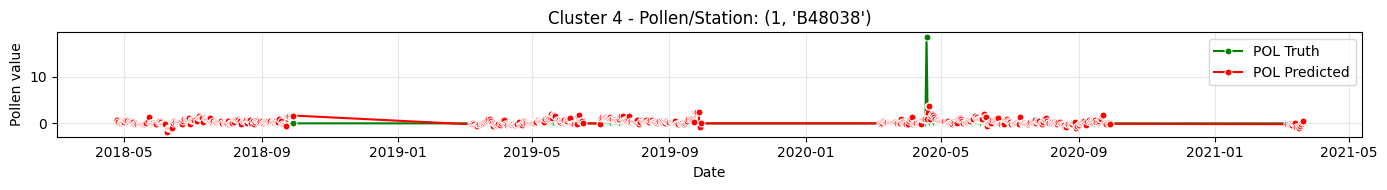

2023-04-04 15:05:15.253014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [535,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:15.253243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


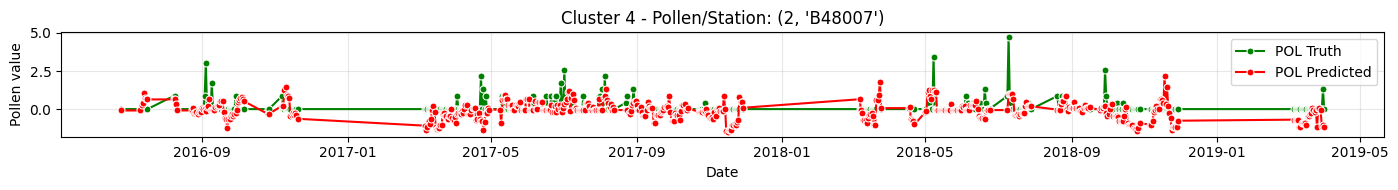

2023-04-04 15:05:15.663579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:15.663936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [510]
	 [[{{node Placeholder/_8}}]]


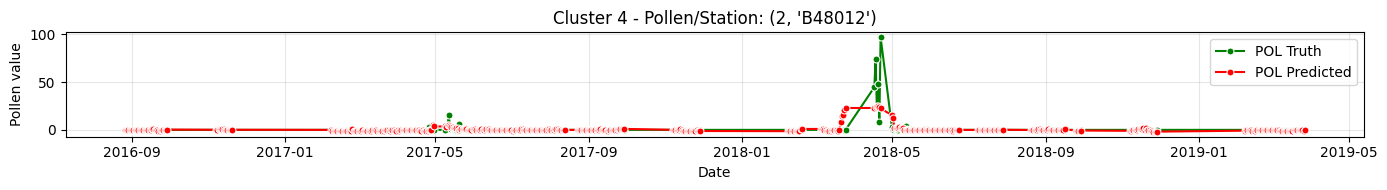

2023-04-04 15:05:15.920631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [399,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:15.920942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


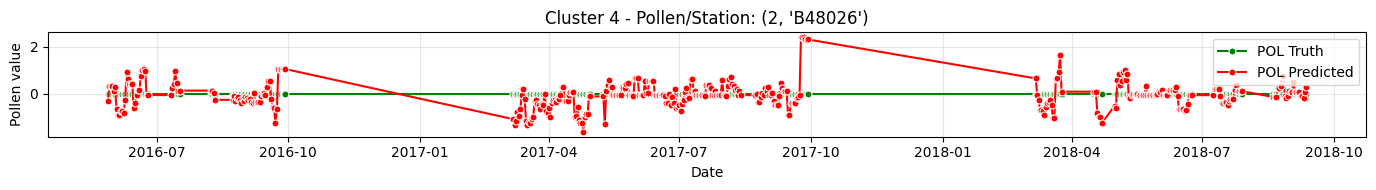

2023-04-04 15:05:16.172475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:16.172749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


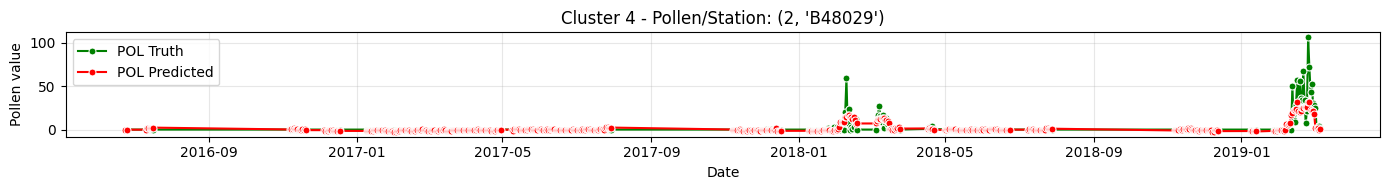

2023-04-04 15:05:16.418843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:16.419198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [523,41]
	 [[{{node Placeholder/_0}}]]


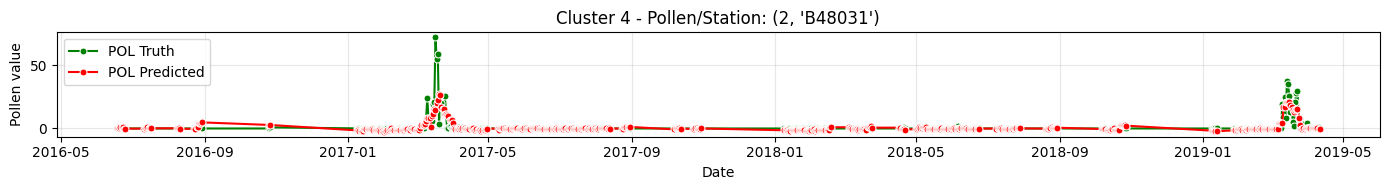

2023-04-04 15:05:16.670463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [395]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:16.670728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [401,41]
	 [[{{node Placeholder/_0}}]]


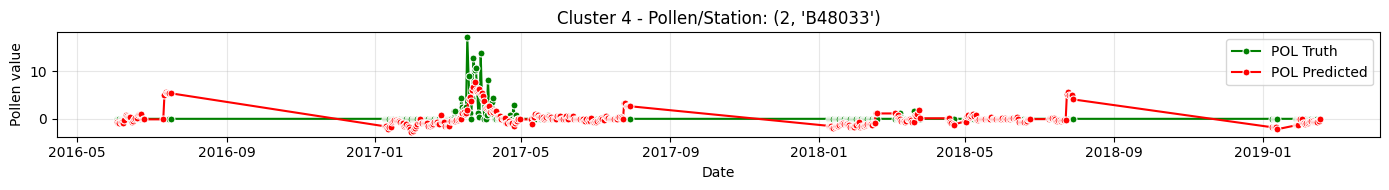

2023-04-04 15:05:16.917084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:16.917362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [449,41]
	 [[{{node Placeholder/_0}}]]


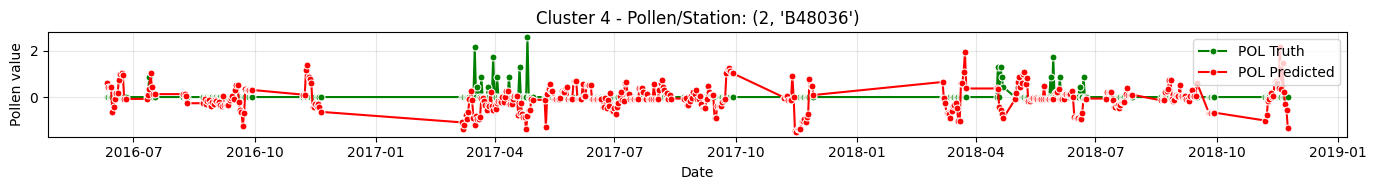

2023-04-04 15:05:17.181384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [334]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:17.181674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


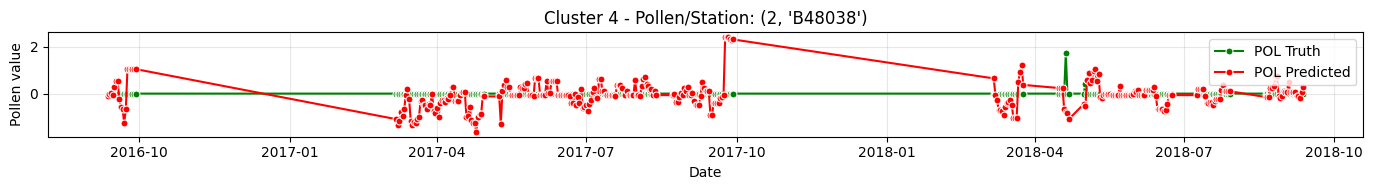

2023-04-04 15:05:17.422527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [528]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:17.422773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [528]
	 [[{{node Placeholder/_8}}]]


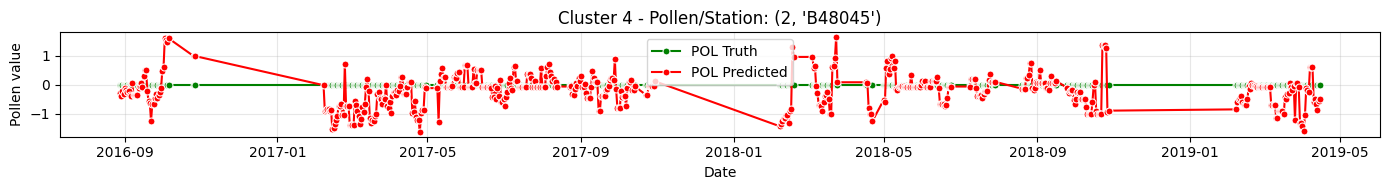

2023-04-04 15:05:17.689022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:17.689257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


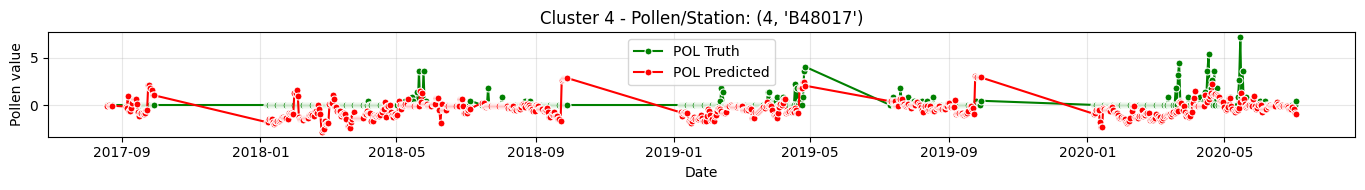

2023-04-04 15:05:17.975702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [488,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:17.975963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [488,41]
	 [[{{node Placeholder/_0}}]]


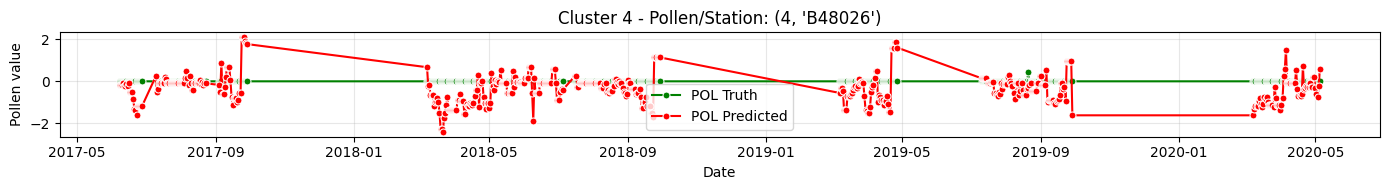

2023-04-04 15:05:18.248477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:18.248723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [487,41]
	 [[{{node Placeholder/_0}}]]


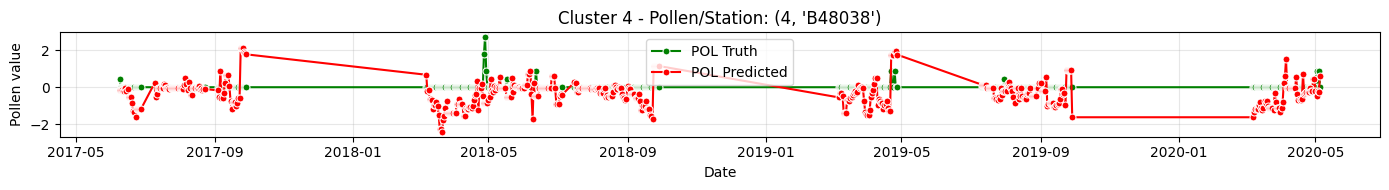

2023-04-04 15:05:18.500508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [652,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:18.500764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


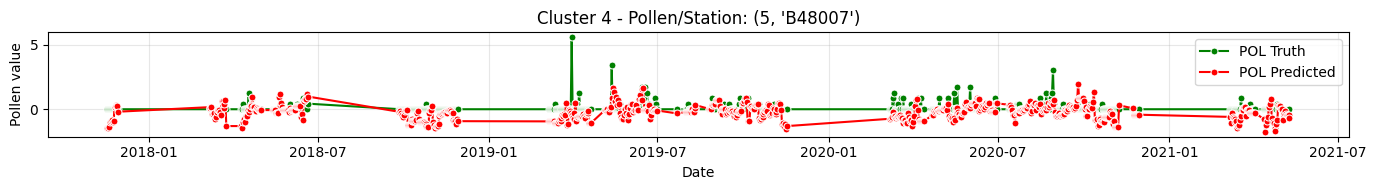

2023-04-04 15:05:18.761736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:18.761980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


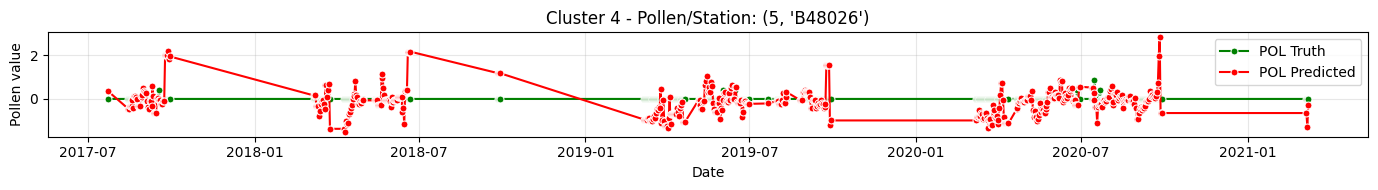

2023-04-04 15:05:19.014002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:19.014258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [625]
	 [[{{node Placeholder/_8}}]]


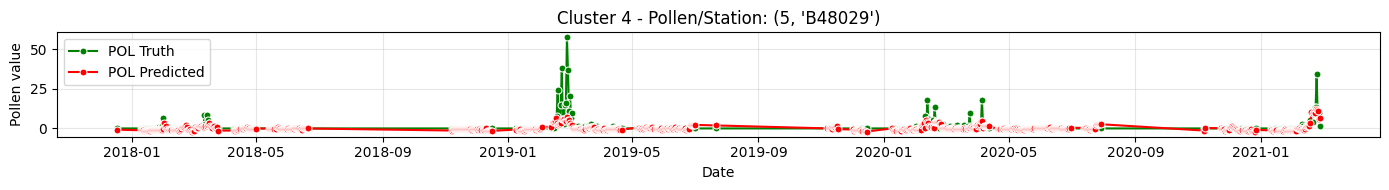

2023-04-04 15:05:19.267924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [543,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:19.268148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [537]
	 [[{{node Placeholder/_8}}]]


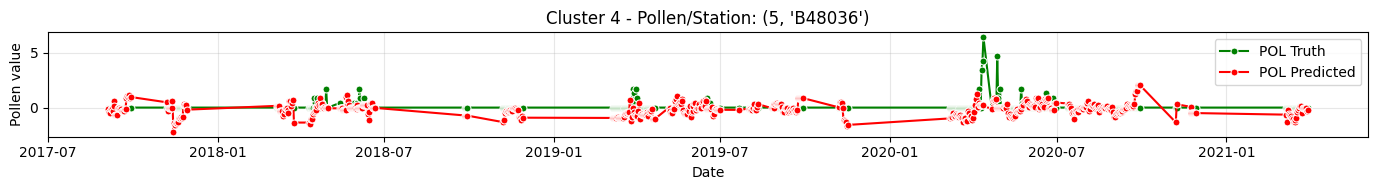

2023-04-04 15:05:19.515092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [403]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:19.515335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [409,41]
	 [[{{node Placeholder/_0}}]]


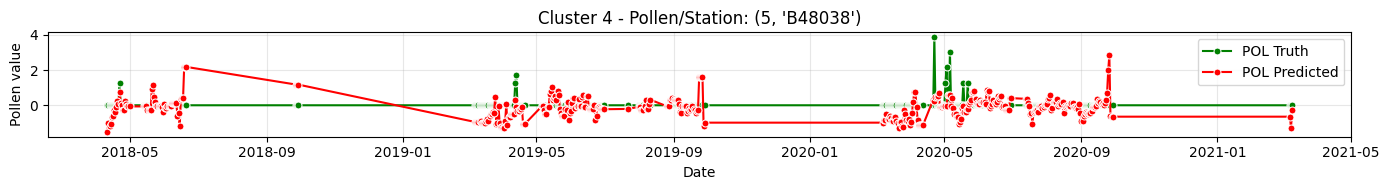

2023-04-04 15:05:19.765168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [644,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:19.765413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


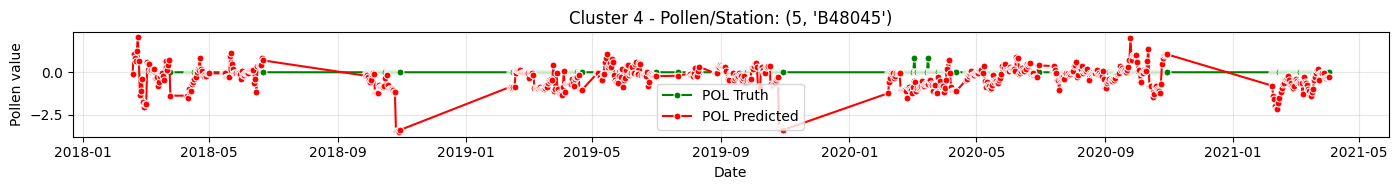

2023-04-04 15:05:20.031495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [494,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:20.031731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


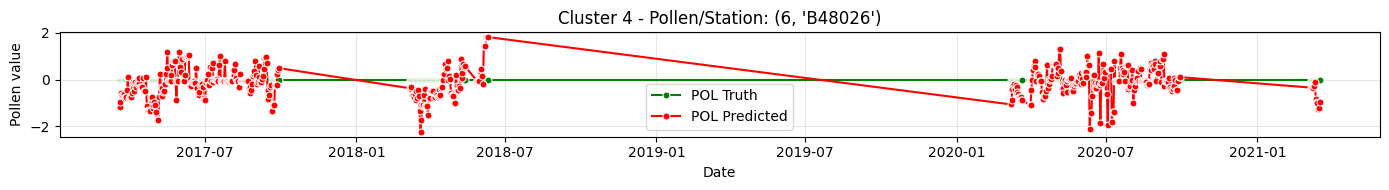

2023-04-04 15:05:20.287814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [411]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:20.288098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


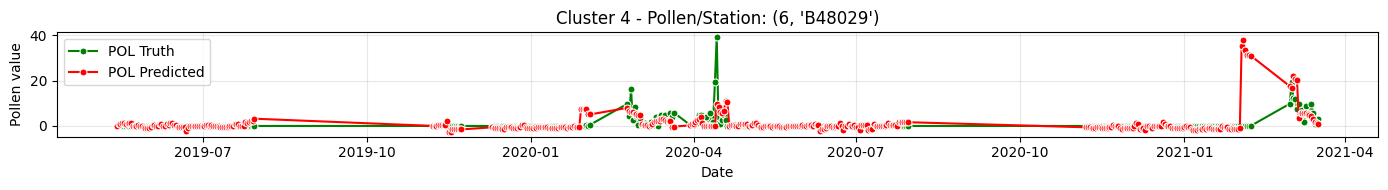

2023-04-04 15:05:20.532308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:20.532527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [550,41]
	 [[{{node Placeholder/_0}}]]


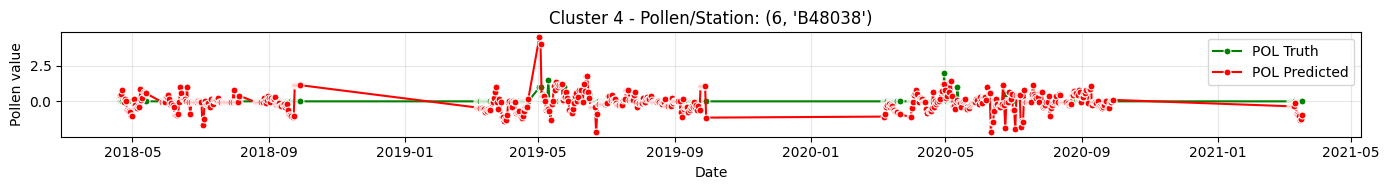

2023-04-04 15:05:20.791841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [698]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:20.792065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [698]
	 [[{{node Placeholder/_8}}]]


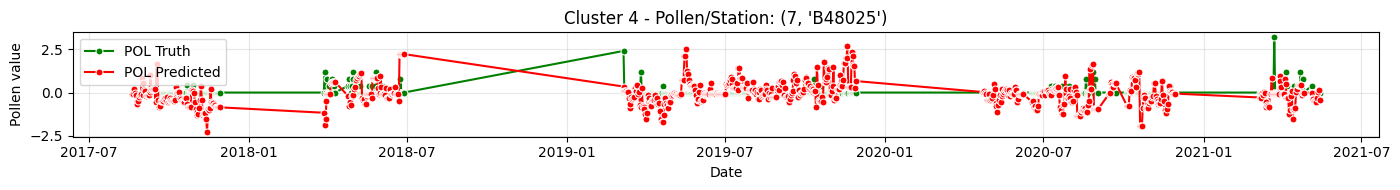

2023-04-04 15:05:21.067168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [530,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:21.067386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [524]
	 [[{{node Placeholder/_8}}]]


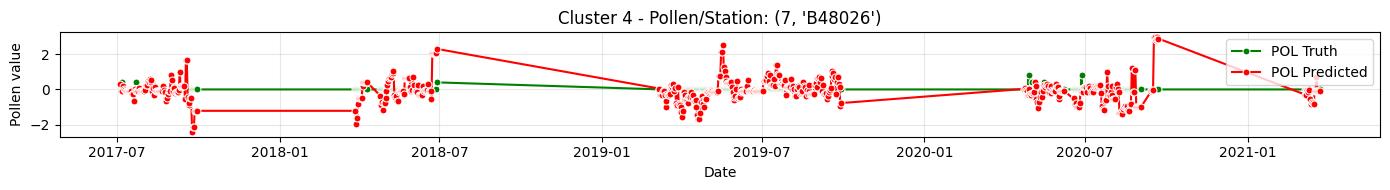

2023-04-04 15:05:21.335681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [689,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:21.335912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


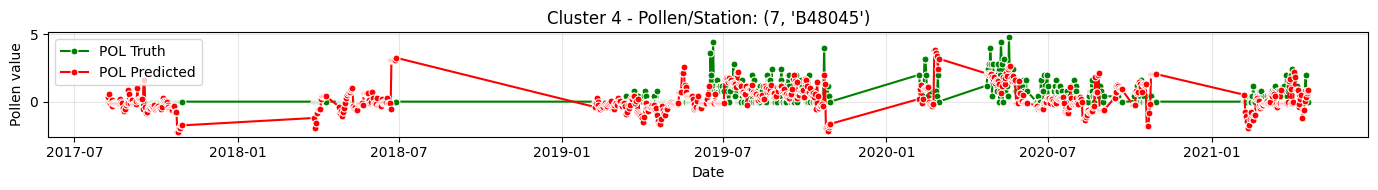

2023-04-04 15:05:21.609605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [707,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:21.609894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


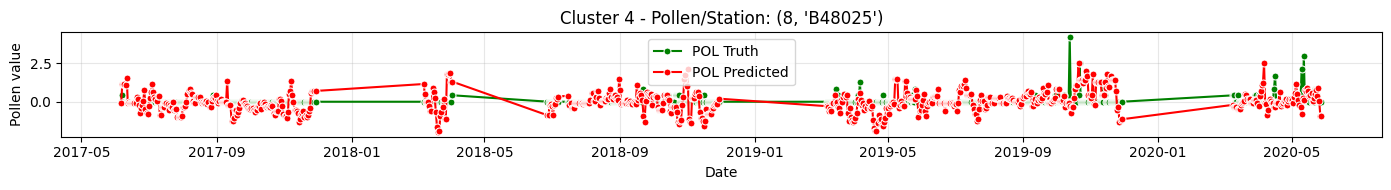

2023-04-04 15:05:21.889317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [518]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:21.889536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


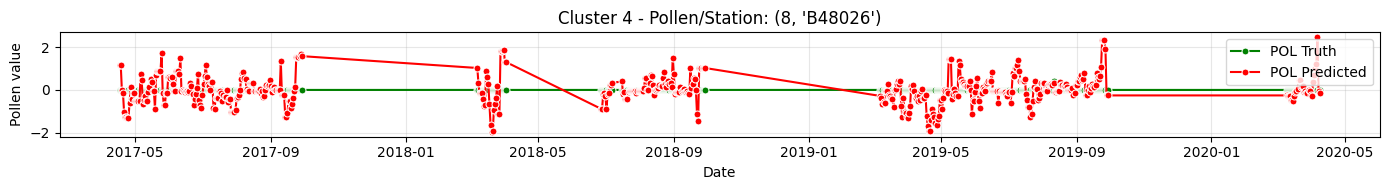

2023-04-04 15:05:22.173242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [155]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:22.173484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [161,41]
	 [[{{node Placeholder/_0}}]]


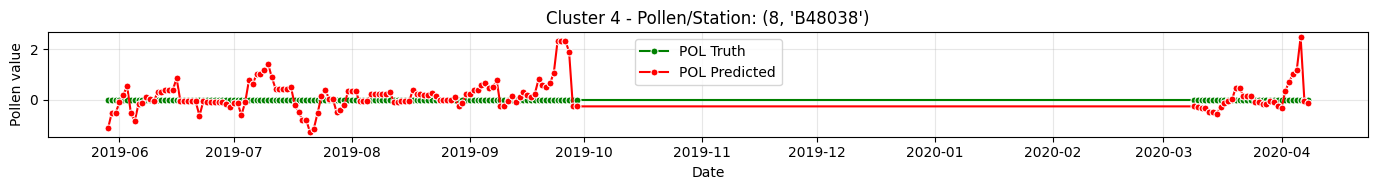

2023-04-04 15:05:22.419356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:22.419593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [673]
	 [[{{node Placeholder/_8}}]]


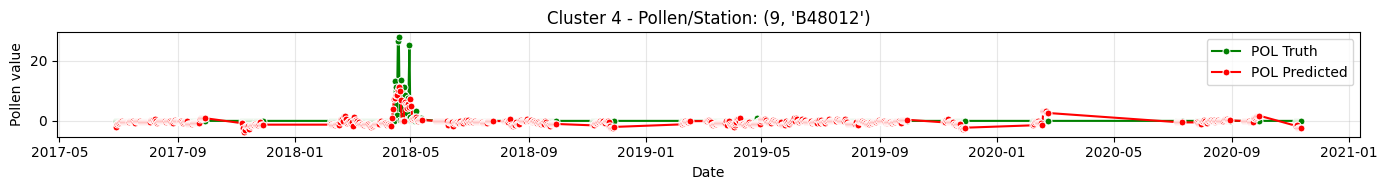

2023-04-04 15:05:22.712445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [531,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:22.712674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


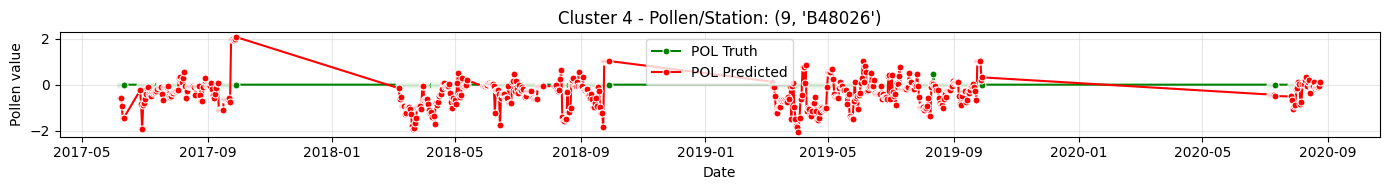

2023-04-04 15:05:23.167708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [686,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:23.168092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


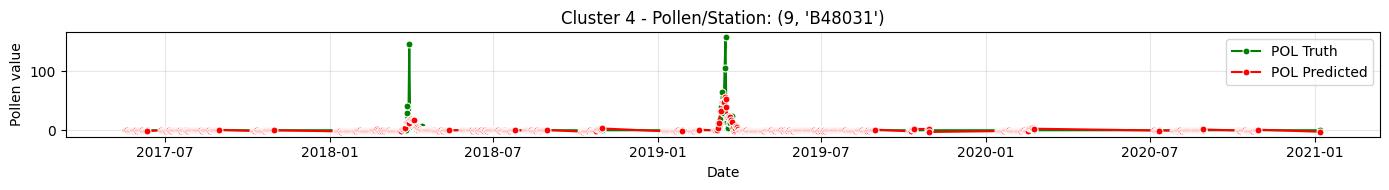

2023-04-04 15:05:23.439572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [600,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:23.439959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


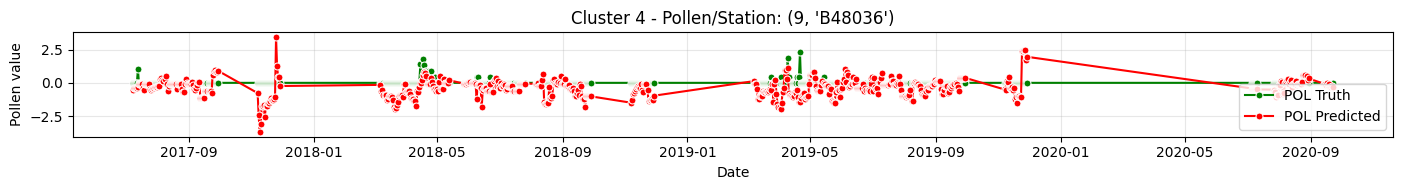

2023-04-04 15:05:23.723463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [132]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:23.723839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


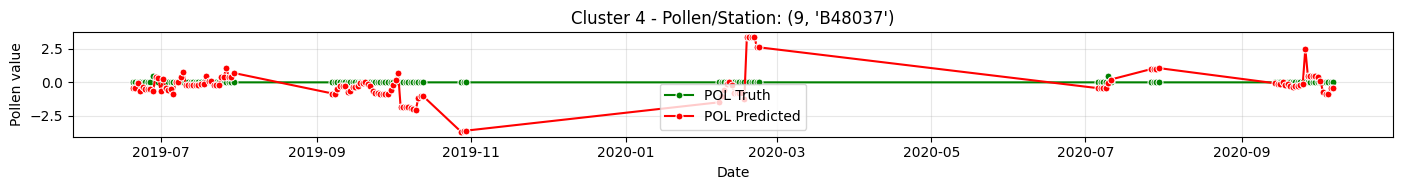

2023-04-04 15:05:23.962241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [129,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:23.962622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


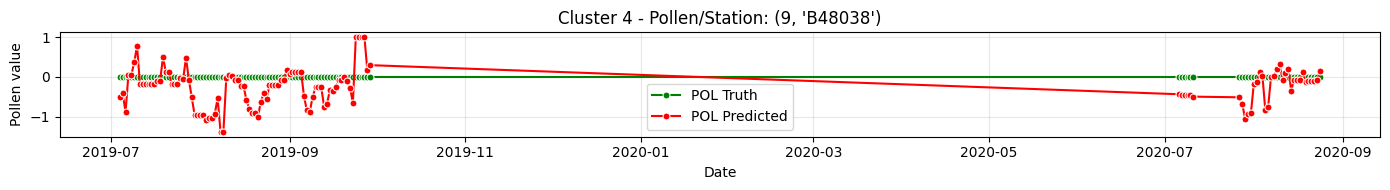

2023-04-04 15:05:24.194711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:24.195020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [475]
	 [[{{node Placeholder/_8}}]]


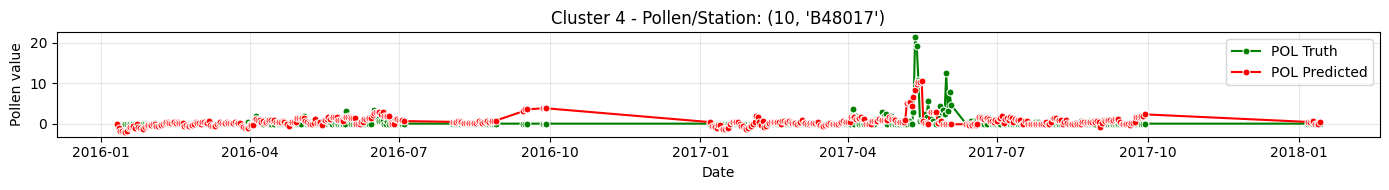

2023-04-04 15:05:24.439637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:24.439941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [496,41]
	 [[{{node Placeholder/_0}}]]


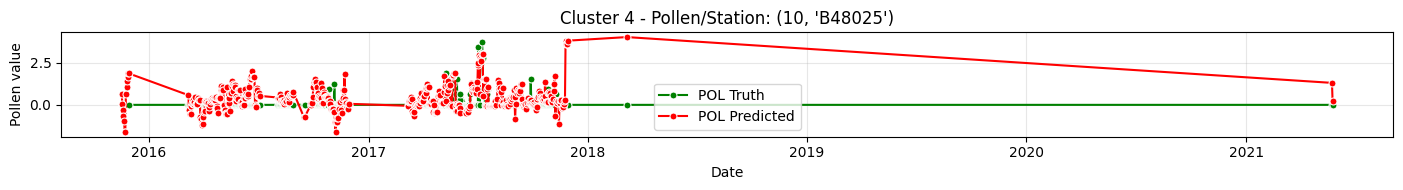

2023-04-04 15:05:24.674406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:24.674718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


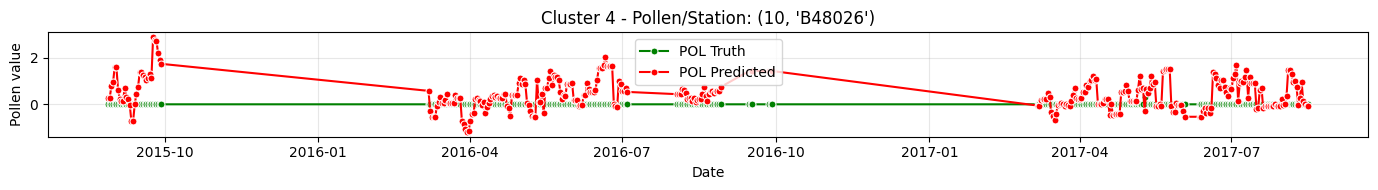

2023-04-04 15:05:24.930549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:24.930854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [347,41]
	 [[{{node Placeholder/_0}}]]


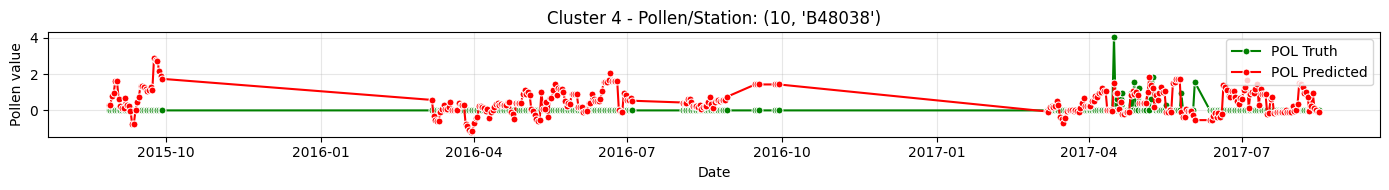

2023-04-04 15:05:25.180159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [576,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:25.180409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


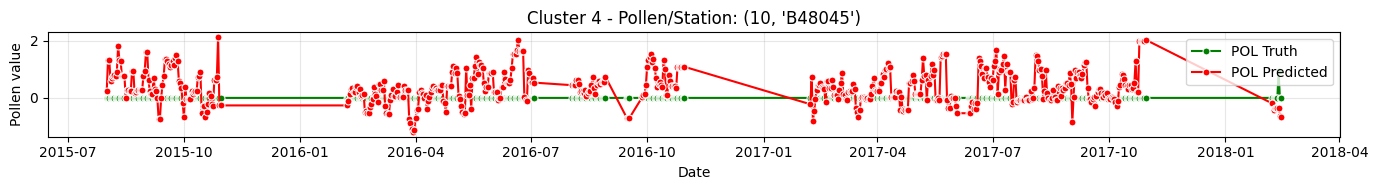

2023-04-04 15:05:25.449979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [581,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:25.450224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


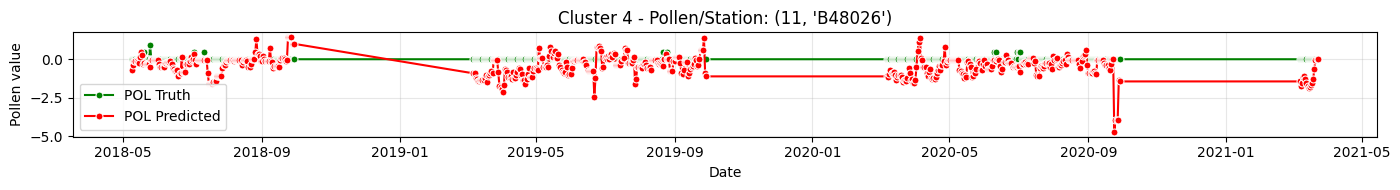

2023-04-04 15:05:25.718289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:25.718518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [173,41]
	 [[{{node Placeholder/_0}}]]


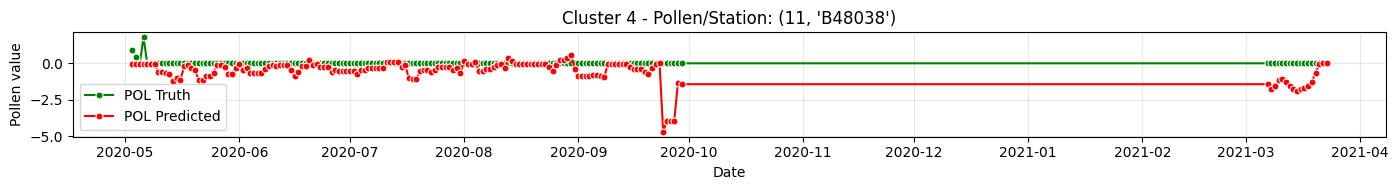

2023-04-04 15:05:25.982038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:25.982334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [542,41]
	 [[{{node Placeholder/_0}}]]


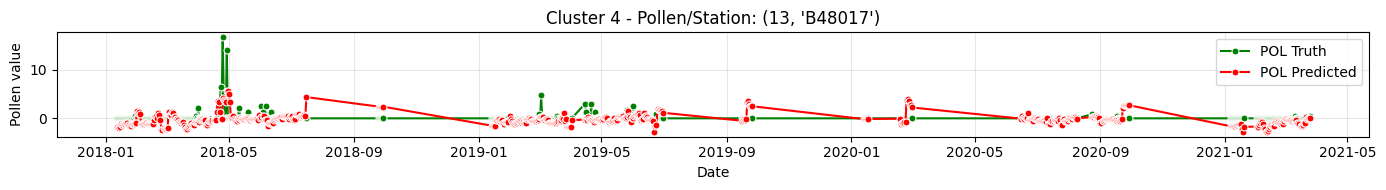

2023-04-04 15:05:26.261733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-04 15:05:26.261979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


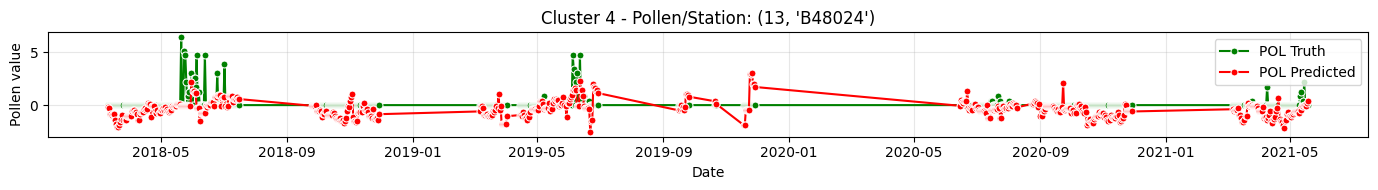

2023-04-04 15:05:26.519977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:26.520224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [422,41]
	 [[{{node Placeholder/_0}}]]


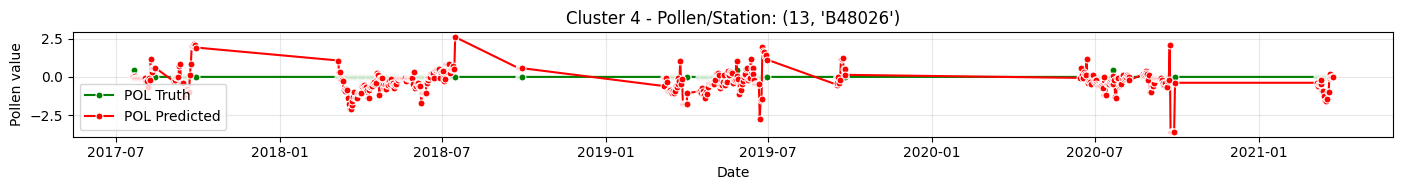

2023-04-04 15:05:26.768205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [105,41]
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:05:26.768508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


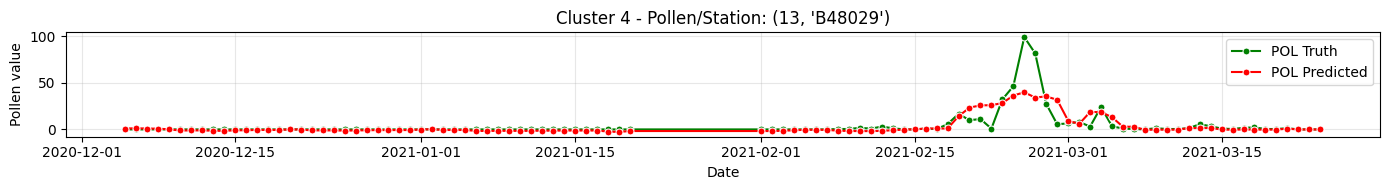

2023-04-04 15:05:26.992562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [415]
	 [[{{node Placeholder/_8}}]]
2023-04-04 15:05:26.992807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [421,41]
	 [[{{node Placeholder/_0}}]]


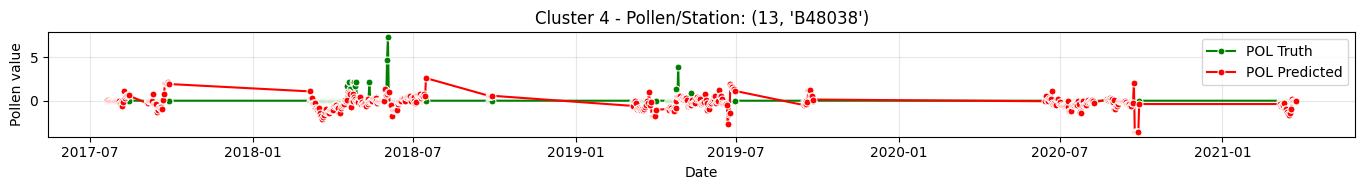

2023-04-04 15:05:27.234766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-04 15:05:27.235031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


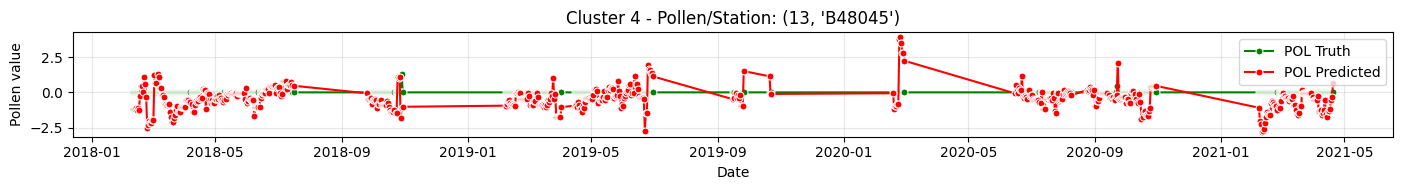

In [40]:
### Per specie/pollen prediction
specie_pollen_dataset = list(filter(lambda d: d.cluster_n == cluster_wgt.value, trainings))[0]

predictions = specie_pollen_dataset.model.predict(specie_pollen_dataset.valid_dataset, verbose=False).squeeze()
mse = specie_pollen_dataset.model.evaluate(specie_pollen_dataset.valid_dataset, verbose=False)

feat = specie_pollen_dataset.features
for group_idx, specie_group in specie_pollen_dataset.x_valid.groupby(["station_id", "pol_var_id"]):
    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        specie_group[feat],
        targets=None,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )
    specie_group = specie_group[: -window_day_size + 1]

    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)

    plt.figure(figsize=(14, 2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value_label, marker="o", markersize=5, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=5, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

___

# 7. Feature Importance

In [ ]:
sample_df = specie_pollen_dataset.x_valid
print(f"Evaluating feature importance on validation set of cluster {specie_pollen_dataset.cluster_n}")

In [ ]:
features = specie_pollen_dataset.features
x_valid = specie_pollen_dataset.x_valid[features].values
y_valid = specie_pollen_dataset.y_valid[: -window_day_size + 1].values.flatten()
results = []

# Evaluate model baseline with all features
oof_preds = specie_pollen_dataset.model.predict(specie_pollen_dataset.valid_dataset, verbose=0).squeeze()
baseline_mse = ((oof_preds - y_valid)**2).mean()
results.append({'feature': 'BASELINE', 'mse': baseline_mse})

for k, f in tqdm(enumerate(features), total=len(features)):
    x_valid_test = x_valid.copy()

    # shuffle feature k
    np.random.shuffle(x_valid_test[:,k])

    # predict and evaluate mse
    x_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(x_valid_test, targets=None, sequence_length=window_day_size, batch_size=batch_size)
    y_pred_shuffled = specie_pollen_dataset.model.predict(x_valid_ds, verbose=0).squeeze() 
    feat_mse = ((y_valid - y_pred_shuffled)**2).mean()
    results.append({'feature': f, 'mse': feat_mse})

In [ ]:
df = pd.DataFrame(results).sort_values('mse')
plt.figure(figsize=(10,28))
plt.title('Model Feature Importance',size=16)
plt.barh(np.arange(len(df)), df.mse)
plt.plot([baseline_mse,baseline_mse], [-1,len(df)], '--', color='orange', label=f'Baseline OOF\nMSE={baseline_mse:.3f}')
plt.xlabel(f'OOF MSE',size=14)
plt.ylabel('Feature',size=14)
plt.yticks(np.arange(len(df)),df.feature.values)
plt.ylim((-1,len(df)))
plt.legend()
plt.show()

___

# 8. Test prediction

In [ ]:
sample_df = specie_pollen_dataset.x_valid
features = specie_pollen_dataset.features
print(f"Testing prediction of validation set of cluster {specie_pollen_dataset.cluster_n}")

In [ ]:
results = []
for _ in tqdm(range(100)):
    # Get random station/pollen
    sample_station_id, sample_pol_var_id = sample_df.sample(1)[["station_id", "pol_var_id"]].iloc[0].values

    # Get selected pollen data
    sample_df = sample_df[(sample_df.station_id == sample_station_id) & (sample_df.pol_var_id == sample_pol_var_id)]

    # Get a sample with some pollen filled
    y_sample = 0
    while y_sample <= 0:
        start_idx = np.random.randint(len(sample_df)-window_day_size)
        end_idx = start_idx + window_day_size

        x_sample = sample_df.iloc[start_idx : end_idx][features]
        y_sample = sample_df.iloc[start_idx+window_day_size]["pol_value_label"]

    x_sample_ds = tf.keras.preprocessing.timeseries_dataset_from_array(x_sample, targets=None, sequence_length=window_day_size, batch_size=1)
    y_sample_pred = specie_pollen_dataset.model.predict(x_sample_ds, verbose=False).squeeze()
    results.append([y_sample, y_sample_pred])
results = np.array(results)

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(results)), results[:,0], c="blue", label="truth");
plt.plot(np.arange(len(results)), results[:,1], c="red", label="pred");
plt.xlabel('Entry')
plt.ylabel('pol value')
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12, 2))
diff = results[:,1] - results[:,0]
plt.bar(np.arange(100), diff)
plt.xlabel('Data point')
plt.ylabel('Difference')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.hist(diff, bins=50);
plt.xlabel('Prediction diff')
plt.ylabel('Distr')
plt.tight_layout()
plt.show()